In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

import os
import torch

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.models.monet_ae import MonetDense
from spatial.predict_xenium import test

import hydra
from hydra.experimental import compose, initialize

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

In [2]:
ckpt_dir = "/nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDenseXenium"

# Initialize an empty dictionary to store the results
test_loss_rad_dict = {}

# Iterate through all files in the directory
for filename in os.listdir(ckpt_dir):
    # Check if the file is a checkpoint file
    if filename.endswith('.ckpt'):
        model_name, hidden_layers, num_kernels, radius, run_name, optim, num_splits = filename.split("__")
        num_splits = num_splits.removesuffix(".ckpt")
        num_splits = num_splits.removeprefix("NUM_SPLITS=")
        if '256' in hidden_layers:
            continue
        with initialize(config_path="../config"):
            # try:
                try:
                    cfg_from_terminal = compose(config_name="configXenium")
                    OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
                    OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", int(num_kernels))
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", eval(hidden_layers))
                    OmegaConf.update(cfg_from_terminal, "training.logger_name", run_name)
                    OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
                    OmegaConf.update(cfg_from_terminal, "radius", int(radius))
                    OmegaConf.update(cfg_from_terminal, "gpus", [2])
                    OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", int(num_splits))
                    print(cfg_from_terminal.training.filepath)
                    output = test(cfg_from_terminal)
                    trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
                    # Store the results over (radius, num_kernels) in a nested dict
                    if int(radius) not in test_loss_rad_dict:
                        test_loss_rad_dict[int(radius)] = {}
                    test_loss_rad_dict[int(radius)][int(num_kernels)] = test_results_BASE[0]['test_loss']
                except Exception as e:
                    if "CUDA out of memory" in str(e):
                        OmegaConf.update(cfg_from_terminal, "training.filepath", "${model.name}__${model.kwargs.kernel_size}__${radius}__${training.logger_name}__${optimizer.name}__NUM_SPLITS=" + str(num_splits))
                        OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 5)
                        print("Increasing splits to 5 due to OOM error.")
                        output = test(cfg_from_terminal)
                        trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
                        # Store the results over (radius, num_kernels) in a nested dict
                        if int(radius) not in test_loss_rad_dict:
                            test_loss_rad_dict[int(radius)] = {}
                        test_loss_rad_dict[int(radius)][int(num_kernels)] = test_results_BASE[0]['test_loss']
                    else:
                        raise e


/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


MonetDense__[512, 512, 512, 512]__10__3__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


The number of parameters for radius 3 is 10967684


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: |          | 0/? [00:00<?, ?it/s]

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2532. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2531. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.31748491525650024    │
│       test_loss_mse       │    0.31748491525650024    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__11__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 11 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.31538236141204834    │
│       test_loss_mse       │    0.31538236141204834    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__16__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 16 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.34191134572029114    │
│       test_loss_mse       │    0.34191134572029114    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__0__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 0 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3183799982070923     │
│       test_loss_mse       │    0.3183799982070923     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__7__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 7 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3166100084781647     │
│       test_loss_mse       │    0.3166100084781647     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__8__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 8 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.31995123624801636    │
│       test_loss_mse       │    0.31995123624801636    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__14__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 14 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.32323941588401794    │
│       test_loss_mse       │    0.32323941588401794    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__10__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 10 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3196830451488495     │
│       test_loss_mse       │    0.3196830451488495     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__15__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 15 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3371899724006653     │
│       test_loss_mse       │    0.3371899724006653     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__19__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 19 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3098253905773163     │
│       test_loss_mse       │    0.3098253905773163     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__6__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 6 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.31778082251548767    │
│       test_loss_mse       │    0.31778082251548767    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__17__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 17 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.35174760222435      │
│       test_loss_mse       │     0.35174760222435      │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__9__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 9 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.33210620284080505    │
│       test_loss_mse       │    0.33210620284080505    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__2__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 2 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3110404312610626     │
│       test_loss_mse       │    0.3110404312610626     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__5__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 5 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3154315948486328     │
│       test_loss_mse       │    0.3154315948486328     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__18__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 18 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3317837715148926     │
│       test_loss_mse       │    0.3317837715148926     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__1__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 1 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3260442018508911     │
│       test_loss_mse       │    0.3260442018508911     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__20__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 20 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.310133159160614     │
│       test_loss_mse       │     0.310133159160614     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__12__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 12 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3349367380142212     │
│       test_loss_mse       │    0.3349367380142212     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__13__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 13 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.30644792318344116    │
│       test_loss_mse       │    0.30644792318344116    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

MonetDense__[512, 512, 512, 512]__10__4__XENIUM__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 4 is 10967684


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.32090893387794495    │
│       test_loss_mse       │    0.32090893387794495    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  184            	

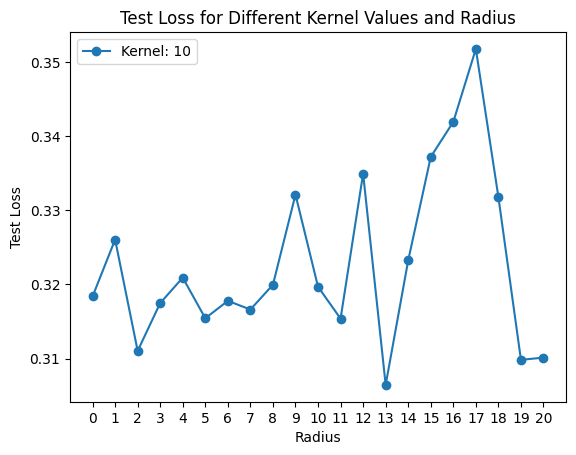

In [3]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store the losses for each kernel value
kernel_losses = {}

# Iterate through the test_loss_rad_dict to populate kernel_losses
for radius, radius_losses in sorted(test_loss_rad_dict.items()):
    for kernel, loss in radius_losses.items():
        if kernel not in kernel_losses:
            kernel_losses[kernel] = []
        kernel_losses[kernel].append((radius, loss))

# Plot the losses for each kernel value
for kernel, losses in kernel_losses.items():
    radii, losses = zip(*losses)  # Unpack the list of tuples into two separate tuples
    plt.plot(radii, losses, label=f"Kernel: {kernel}", marker='o')

plt.xlabel("Radius")
plt.ylabel("Test Loss")
plt.title("Test Loss for Different Kernel Values and Radius")
plt.xticks(range(0, 21, 1))  # Set x-axis tick marks to integers
plt.legend()
plt.show()